<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/InterpretProfileModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/9e9880e93fef6c41b5ac40f33142b80305aae4f2/bqtls/profile_model/Spi1ProfileModel_rc.h5 -O Spi1ProfileModel_rc.h5

--2019-10-18 01:50:41--  https://raw.githubusercontent.com/AvantiShri/model_storage/9e9880e93fef6c41b5ac40f33142b80305aae4f2/bqtls/profile_model/Spi1ProfileModel_rc.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2078176 (2.0M) [application/octet-stream]
Saving to: ‘Spi1ProfileModel_rc.h5’

Spi1ProfileModel_rc 100%[===================>]   1.98M  2.15MB/s    in 0.9s    

2019-10-18 01:50:48 (2.15 MB/s) - ‘Spi1ProfileModel_rc.h5’ saved [2078176/2078176]



In [3]:
!pip install keras_genomics

  Created wheel for keras-genomics: filename=keras_genomics-0.1.1.1-cp36-none-any.whl size=9642 sha256=29989e14e187314d55df5221fcdf2d1b8519c849054ef88744cb8d252cf65d13
  Stored in directory: /root/.cache/pip/wheels/ad/07/53/12c9cab81be5fbb7f824df1cf6d23734f27ce7d52f0675691b
Successfully built keras-genomics


In [4]:
!zcat SPI1.txt.gz | head

gzip: SPI1.txt.gz: No such file or directory


In [5]:
#let's pull in some regions around bqtls to interpret
import gzip
import numpy as np

![[ -f SPI1.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/22db099/bqtls/SPI1.txt.gz -O SPI1.txt.gz

class BQTL(object):
  
  def __init__(self, chr, pos,
               depth, altdepth, refdepth,
               altallele, postallele,
               postfreq, prefreq, pvalue,
               #closest_summit_pos
               ):
    self.chr = chr
    self.start = pos-1
    self.end = pos
    self.depth=depth,
    self.altdepth=altdepth,
    self.refdepth=refdepth,
    self.altallele = altallele
    self.postallele = postallele
    self.postfreq = postfreq
    self.prefreq = prefreq
    self.logratio = np.log((self.postfreq+0.01)/(self.prefreq+0.01))
    self.pvalue = pvalue
    #self.closest_summit_pos = closest_summit_pos
    #self.closest_summit_dist = abs(int(self.closest_summit_pos-self.start))

bqtls = []
for (i,row) in enumerate(gzip.open("SPI1.txt.gz")):
    if (i > 0):
        row = row.decode("utf-8").rstrip()
        (chr, pos, depth, altdept, refdepth,
         altallele, postallele,
         postfreq, prefreq, pvalue) = row.split("\t")
        (pos, depth, altdepth, refdepth,
         postfreq, prefreq, pvalue) =\
         (int(pos), int(depth), int(altdept), int(refdepth),
          float(postfreq), float(prefreq), float(pvalue))
        bqtls.append(BQTL(chr=chr, pos=pos,
                          depth=depth, altdepth=altdepth, refdepth=refdepth,
                          altallele=altallele,
                          postallele=postallele,
                          postfreq=postfreq, prefreq=prefreq, pvalue=pvalue))
        
significant_bqtls = sorted([x for x in bqtls if x.pvalue <= 5e-5],
                           key=lambda x: -np.abs(x.logratio))

--2019-10-18 01:50:55--  https://raw.githubusercontent.com/AvantiShri/model_storage/22db099/bqtls/SPI1.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23850025 (23M) [application/octet-stream]
Saving to: ‘SPI1.txt.gz’

SPI1.txt.gz         100%[===================>]  22.75M  84.8MB/s    in 0.3s    

2019-10-18 01:50:56 (84.8 MB/s) - ‘SPI1.txt.gz’ saved [23850025/23850025]



In [6]:
#The SNPs are all in hg19, so need to download the hg19 genome
#Get hg19 fasta by download 2bit and then converting to fa
![[ -f hg19.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.2bit -O hg19.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg19.genome.fa ]] || ./twoBitToFa hg19.2bit hg19.genome.fa

--2019-10-18 01:51:11--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.2bit
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 816241703 (778M) [text/plain]
Saving to: ‘hg19.2bit’

hg19.2bit           100%[===================>] 778.43M  66.5MB/s    in 14s     

2019-10-18 01:51:26 (55.1 MB/s) - ‘hg19.2bit’ saved [816241703/816241703]

--2019-10-18 01:51:26--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5908792 (5.6M) [text/plain]
Saving to: ‘twoBitToFa’

twoBitToFa          100%[===================>]   5.63M  4.30MB/s    in 1.3s    

2019-10-18 0

In [7]:
!pip install pyfaidx

  Created wheel for pyfaidx: filename=pyfaidx-0.5.5.2-cp36-none-any.whl size=24641 sha256=952f4c8ef832f9e2c04035629fb8eee9cc61dab73c8b61cb0b65f57a0db06ae1
  Stored in directory: /root/.cache/pip/wheels/54/a2/b4/e242e58d23b2808e191b214067880faa46cd2341f363886e0b
Successfully built pyfaidx


In [0]:
def annotate_snps_with_flankinfo(snp_list):
    import pyfaidx
    from pyfaidx import Fasta
    #first time this is executed, will build the index if it's
    # not there
    fasta = Fasta("hg19.genome.fa")
    for (i,snp) in enumerate(snp_list):
        left_flank = fasta[snp.chr][snp.end-673:snp.end].seq
        right_flank = fasta[snp.chr][snp.end:snp.end+673].seq
        snp.left_flank = left_flank
        snp.right_flank = right_flank

annotate_snps_with_flankinfo(significant_bqtls)

In [9]:
!git clone https://github.com/AvantiShri/shap.git
%cd /content/shap
!pip uninstall shap
!git pull
!pip install .
%cd /content

from importlib import reload
import shap
reload(shap.explainers.deep)
reload(shap.explainers)
reload(shap)

Cloning into 'shap'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 4813 (delta 4), reused 3 (delta 0), pack-reused 4800
Receiving objects: 100% (4813/4813), 112.03 MiB | 29.85 MiB/s, done.
Resolving deltas: 100% (3127/3127), done.
Checking out files: 100% (260/260), done.
/content/shap
Already up to date.
Processing /content/shap
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=347373 sha256=3189670f0fd576e8c6e535bfdecf1fd4b2a3b3f2315dfc70f5155a17ffe45223
  Stored in directory: /tmp/pip-ephem-wheel-cache-88gyzgrf/wheels/08/fe/b1/461bb216b26aa22db99708d72d320d2f3637775309af9f79b5
Successfully built shap
/content


<module 'shap' from '/usr/local/lib/python3.6/dist-packages/shap/__init__.py'>

In [10]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import tensorflow as tf
import tensorflow_probability as tfp

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))


#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

#to reload, you need to set up a CustomObjectScope
from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,
                        'RevCompConv1D': RevCompConv1D}):
  model = load_model('Spi1ProfileModel_rc.h5')

model.summary()

Using TensorFlow backend.











Instructions for updating:
Use `tf.cast` instead.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1346, 4)      0                                            
__________________________________________________________________________________________________
rev_comp_conv1d_1 (RevCompConv1 (None, 1326, 128)    5440        sequence[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1322, 128)    0           rev_comp_conv1d_1[0][0]          
__________________________________________________________________________________________________
rev_comp_conv1d_2 (RevCompConv1 (None, 1322, 128)    24640       rev_comp_conv1d_1[0][0]          
_______________________________

In [11]:
!pip install deeplift

  Created wheel for deeplift: filename=deeplift-0.6.9.0-cp36-none-any.whl size=34611 sha256=b08f07a1b8d3e69d95e244e815c81298ce203f1090a13498e610a19a5c4cd1bf
  Stored in directory: /root/.cache/pip/wheels/45/10/2d/2076a56f3ec01f021cfede9df40e40963d2c9301e367bde978
Successfully built deeplift


In [16]:
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in [0]:
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    to_return.append(np.zeros_like(orig_inp[1]))
    return to_return

def shuffle_several_times(s):
    numshuffles=20
    return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
            np.array([s[1] for i in range(numshuffles)])]

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[1]],
     tf.reduce_sum(model.outputs[0],axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

meannormed_logits = (
    model.outputs[1]-
    tf.reduce_mean(model.outputs[1],axis=1)[:,None,:])
stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
softmax_out = tf.nn.softmax(meannormed_logits,axis=1)
weightedsum_meannormed_logits = tf.reduce_sum(softmax_out*meannormed_logits,
                                              axis=(1,2))

profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[2]],
     weightedsum_meannormed_logits),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)


In [18]:
onehot_mapping = {
    'A': [1,0,0,0],
    'C': [0,1,0,0],
    'G': [0,0,1,0],
    'T': [0,0,0,1],
    'a': [1,0,0,0],
    'c': [0,1,0,0],
    'g': [0,0,1,0],
    't': [0,0,0,1],
}

def one_hot_encode(sequence):
  return np.array([onehot_mapping[x] for x in sequence])

def annotate_snps_with_post_and_alt_profile_preds(
    snp_list, profile_model,
    profile_model_counts_explainer,
    profile_model_profile_explainer):
  
    post_onehot = np.array([one_hot_encode(x.left_flank[-672:]
                                            +x.postallele
                                            +x.right_flank[:673])
                            for x in snp_list])
    alt_onehot = np.array([one_hot_encode(x.left_flank[-672:]
                                          +x.altallele
                                          +x.right_flank[:673])
                           for x in snp_list])
    #get predictions when providing zeros for the bias tracks
    post_counts_preds, post_profile_preds = profile_model.predict([
                                                post_onehot,
                                                np.zeros((len(post_onehot), 1)),
                                                np.zeros((len(post_onehot), 1000, 2))])
    alt_counts_preds, alt_profile_preds = profile_model.predict([
                                                alt_onehot,
                                                np.zeros((len(post_onehot), 1)),
                                                np.zeros((len(post_onehot), 1000, 2))])
    
    for (post_counts_pred, alt_counts_pred,
         post_profile_pred, alt_profile_pred, snp) in zip(
            post_counts_preds, alt_counts_preds,
            post_profile_preds, alt_profile_preds, snp_list):
        snp.post_counts_pred = post_counts_pred
        snp.alt_counts_pred = alt_counts_pred
        snp.post_profile_pred = post_profile_pred
        snp.alt_profile_pred = alt_profile_pred
    
    #The shap scores too
    post_counts_hypimps,_ = profile_model_counts_explainer.shap_values(
        [post_onehot, np.zeros((len(post_onehot), 1))],
        progress_message=10)
    alt_counts_hypimps,_ = profile_model_counts_explainer.shap_values(
        [alt_onehot, np.zeros((len(alt_onehot), 1))],
        progress_message=10)
    post_profile_hypimps,_ = profile_model_profile_explainer.shap_values(
        [post_onehot, np.zeros((len(post_onehot), 1000, 2))],
        progress_message=10)
    alt_profile_hypimps,_ = profile_model_profile_explainer.shap_values(
        [alt_onehot, np.zeros((len(alt_onehot), 1000, 2))],
        progress_message=10)
    
    post_counts_actualimps = post_counts_hypimps*post_onehot
    post_profile_actualimps = post_profile_hypimps*post_onehot
    
    alt_counts_actualimps = alt_counts_hypimps*alt_onehot
    alt_profile_actualimps = alt_profile_hypimps*alt_onehot  
    
    for i in range(len(snp_list)):
        snp_list[i].post_counts_hypimp = post_counts_hypimps[i]
        snp_list[i].alt_counts_hypimp = alt_counts_hypimps[i]
        snp_list[i].post_profile_hypimp = post_profile_hypimps[i]
        snp_list[i].alt_profile_hypimp = alt_profile_hypimps[i]
        snp_list[i].post_counts_actualimp = post_counts_actualimps[i]
        snp_list[i].alt_counts_actualimp = alt_counts_actualimps[i]
        snp_list[i].post_profile_actualimp = post_profile_actualimps[i]
        snp_list[i].alt_profile_actualimp = alt_profile_actualimps[i]    

annotate_snps_with_post_and_alt_profile_preds(
    significant_bqtls[:10],
    profile_model=model,
    profile_model_counts_explainer=profile_model_counts_explainer,
    profile_model_profile_explainer=profile_model_profile_explainer)

Done 0 examples of 10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done 0 examples of 10
Done 0 examples of 10
Done 0 examples of 10


idx, snp pos 52536308 52536309 logratio -4.149698596613066 pvalue 4.47043413028584e-10
Post allele, counts pred [2.2654586 2.3232236]
Post allele profile pred


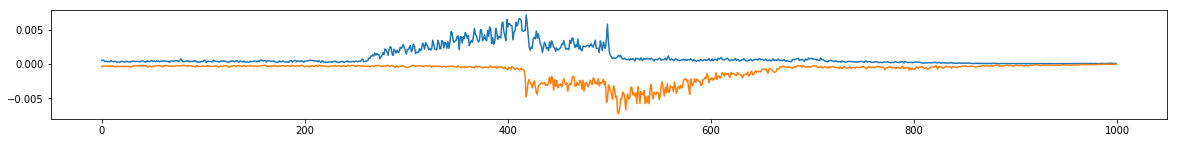

Post allele counts imp


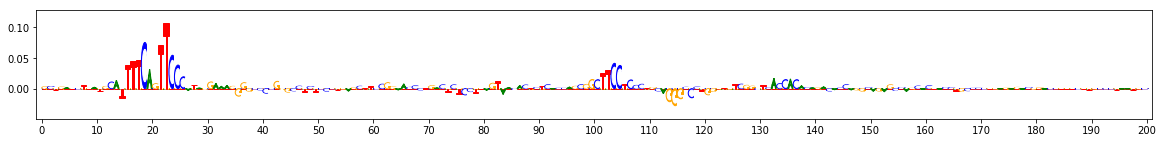

Post allele profile imp


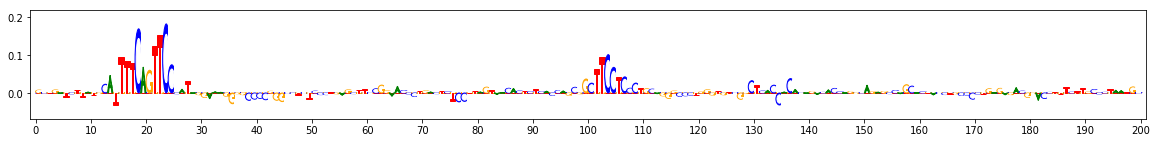

Alt allele:
Alt allele, counts pred [2.5227902 2.5882034]


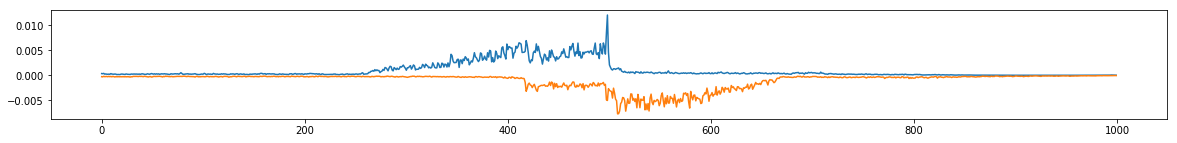

Alt allele counts imp


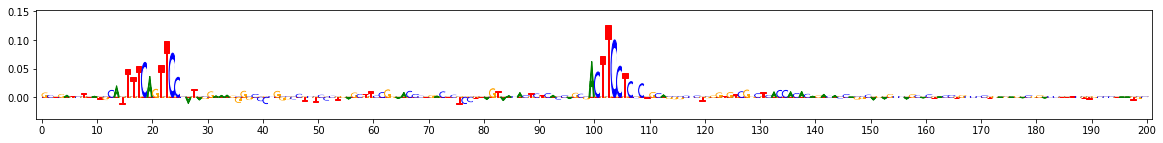

Alt allele profile imp


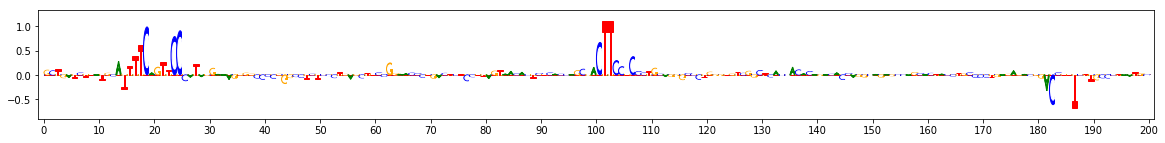

idx, snp pos 21754995 21754996 logratio -4.089977797474426 pvalue 1.20170491449766e-07
Post allele, counts pred [2.1622767 2.1417   ]
Post allele profile pred


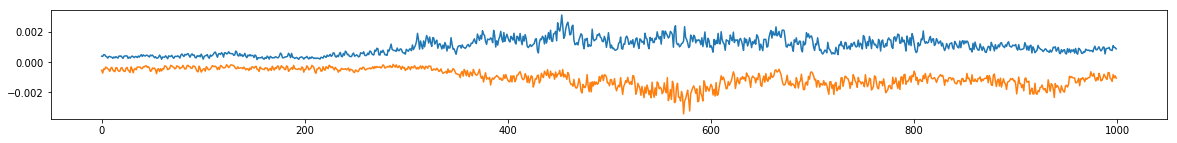

Post allele counts imp


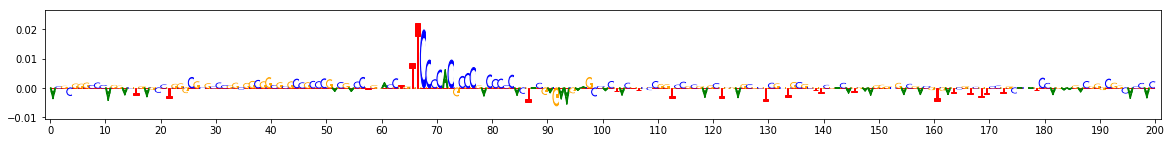

Post allele profile imp


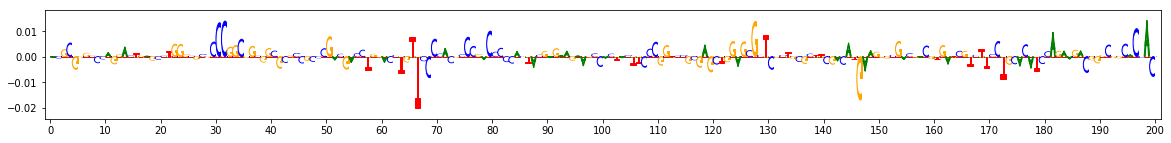

Alt allele:
Alt allele, counts pred [2.1726944 2.1518118]


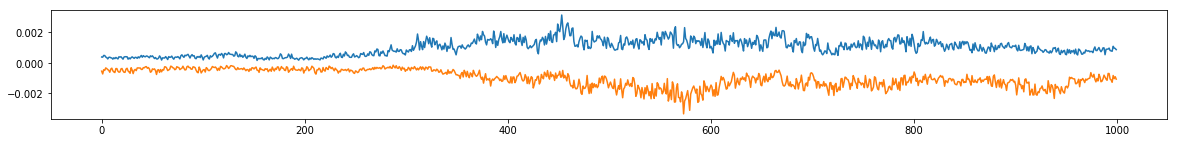

Alt allele counts imp


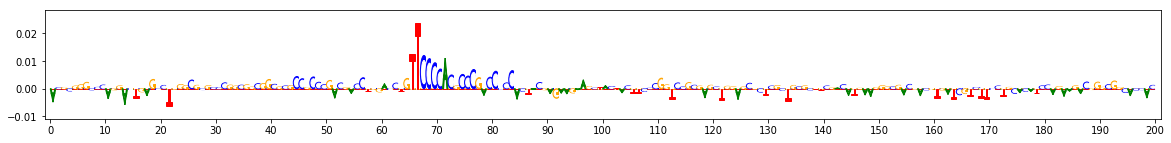

Alt allele profile imp


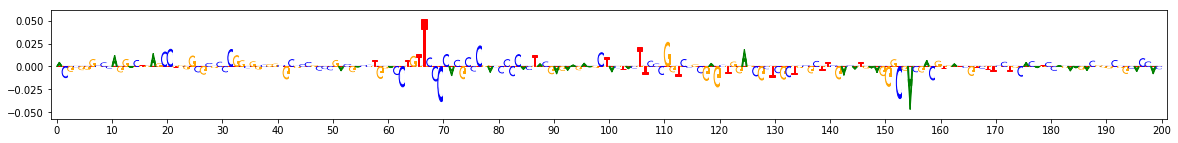

idx, snp pos 216195280 216195281 logratio -4.079079591214075 pvalue 6.66541914880443e-08
Post allele, counts pred [1.9641609 2.00946  ]
Post allele profile pred


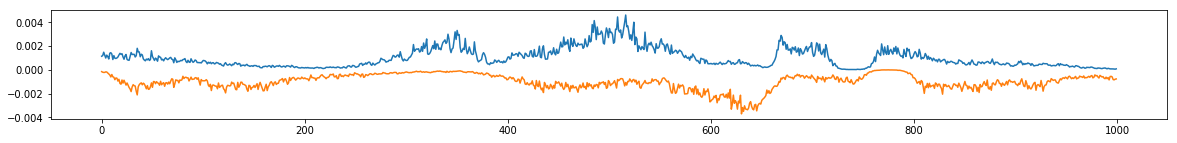

Post allele counts imp


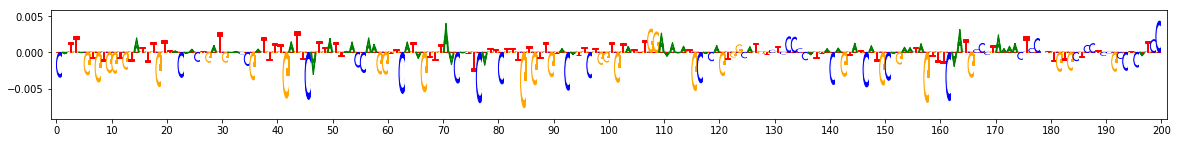

Post allele profile imp


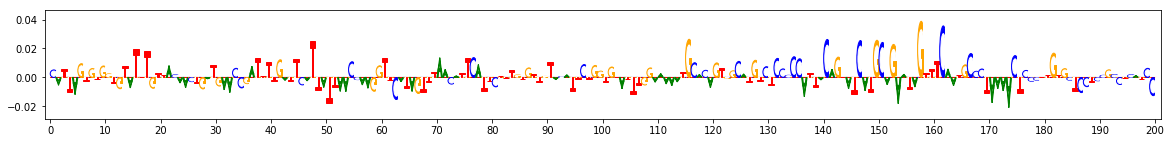

Alt allele:
Alt allele, counts pred [1.9648325 2.0093465]


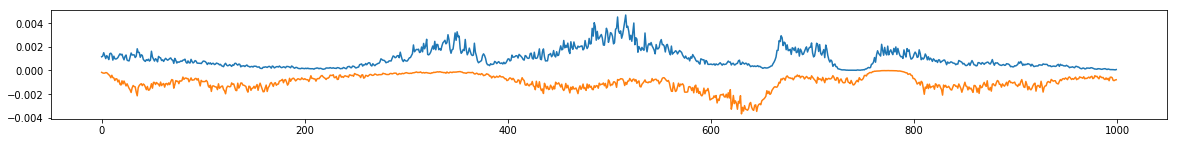

Alt allele counts imp


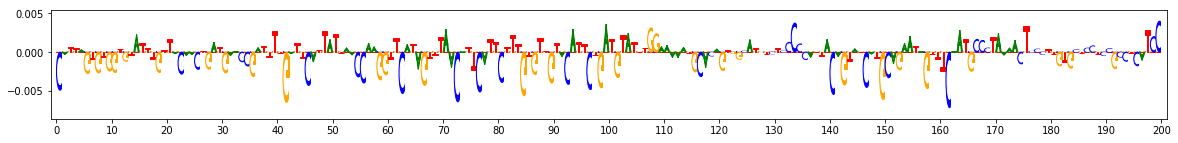

Alt allele profile imp


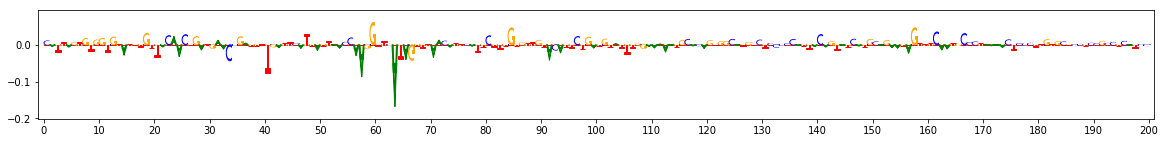

idx, snp pos 94265356 94265357 logratio -4.02117675634378 pvalue 1.38928741655431e-06
Post allele, counts pred [2.0740662 2.0744927]
Post allele profile pred


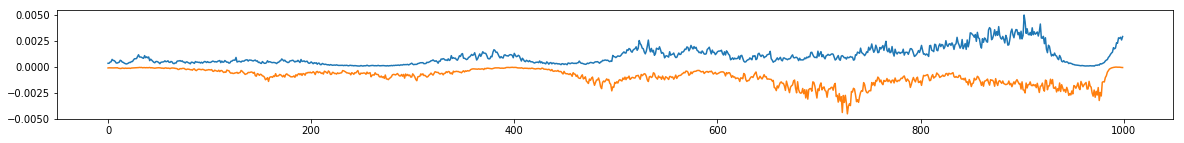

Post allele counts imp


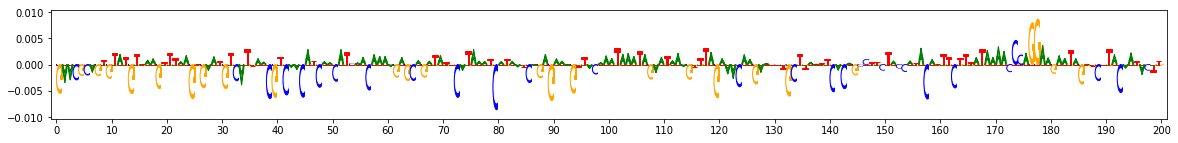

Post allele profile imp


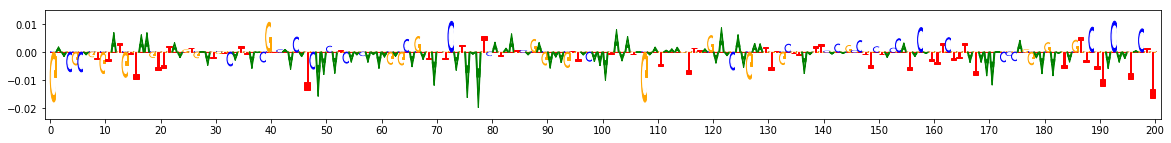

Alt allele:
Alt allele, counts pred [2.0709686 2.071956 ]


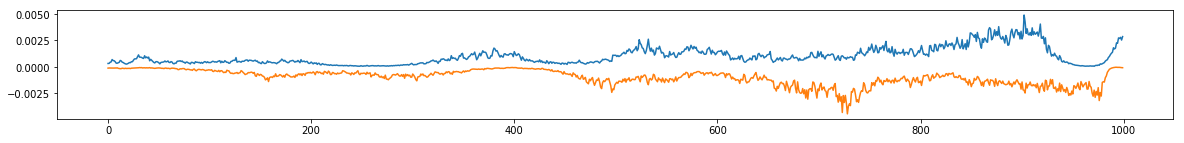

Alt allele counts imp


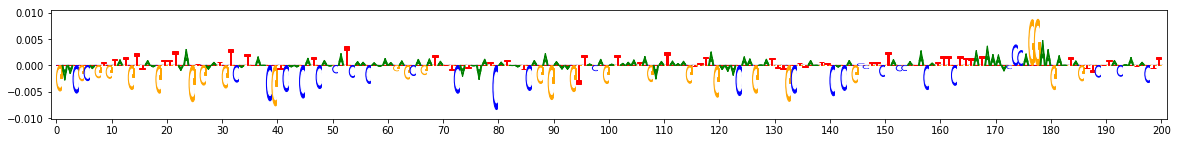

Alt allele profile imp


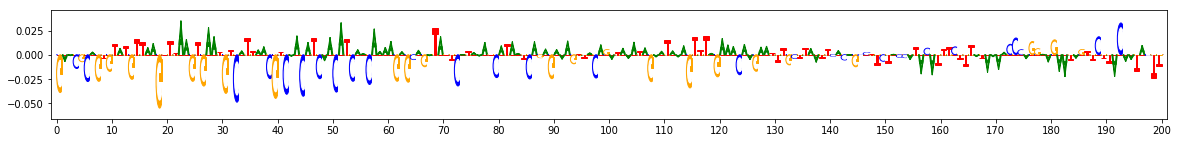

idx, snp pos 60240729 60240730 logratio -3.9636372221769993 pvalue 1.00877383094879e-06
Post allele, counts pred [2.2618186 2.121633 ]
Post allele profile pred


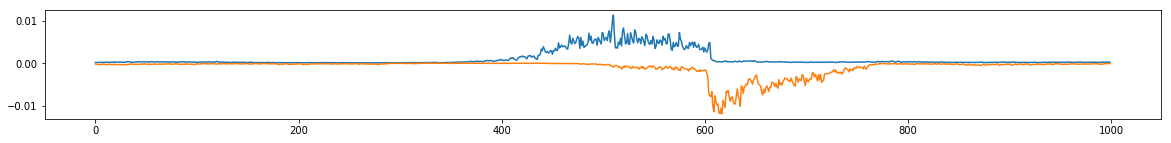

Post allele counts imp


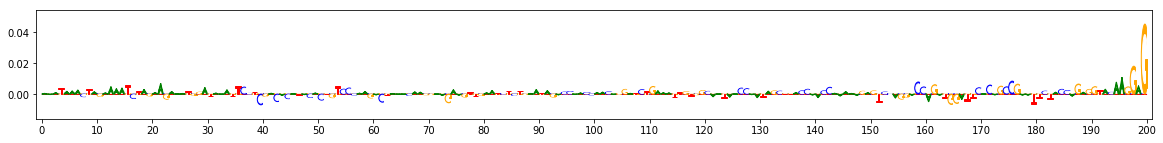

Post allele profile imp


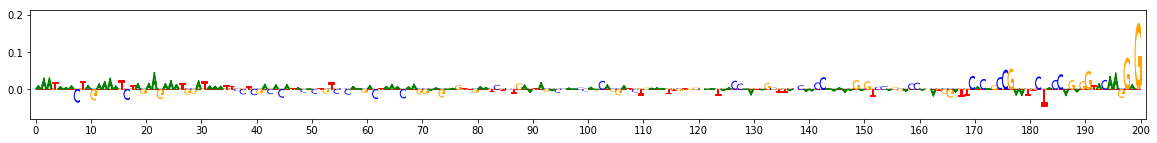

Alt allele:
Alt allele, counts pred [2.3856068 2.2361903]


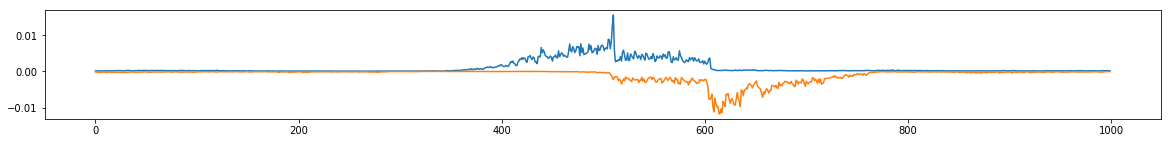

Alt allele counts imp


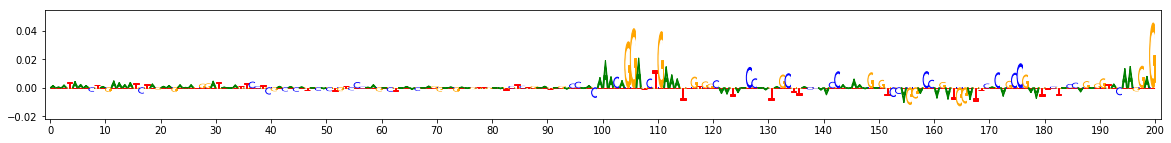

Alt allele profile imp


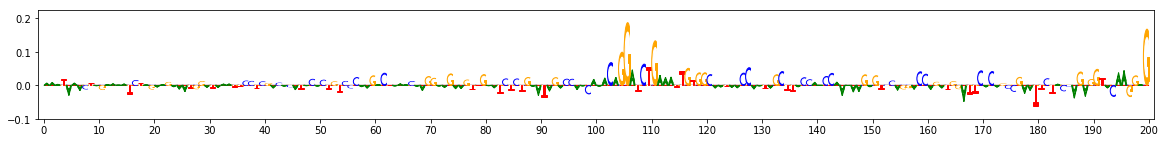

idx, snp pos 104812860 104812861 logratio -3.962963425739213 pvalue 9.02937570040754e-06
Post allele, counts pred [1.9188883 2.0359943]
Post allele profile pred


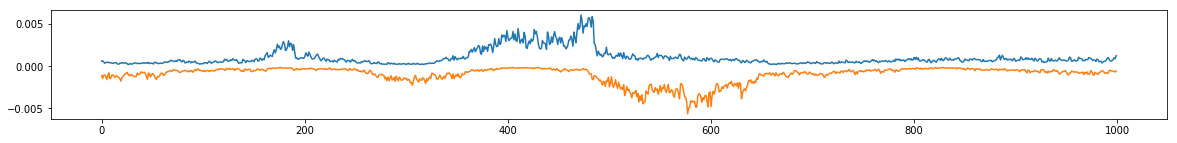

Post allele counts imp


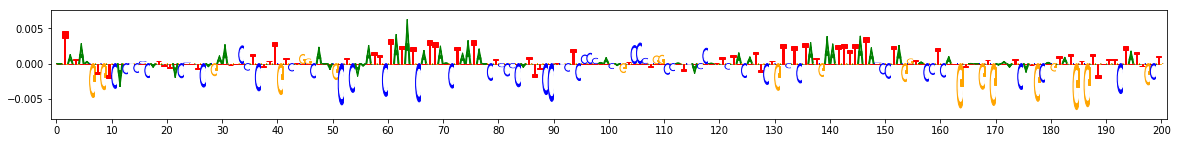

Post allele profile imp


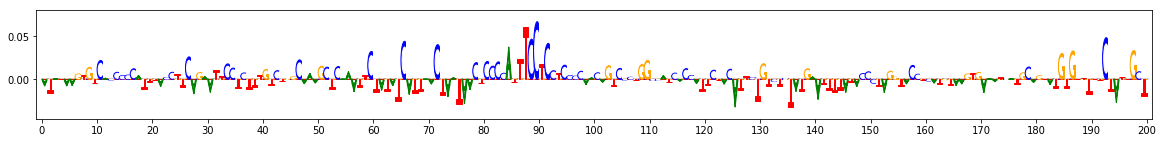

Alt allele:
Alt allele, counts pred [1.9143093 2.031324 ]


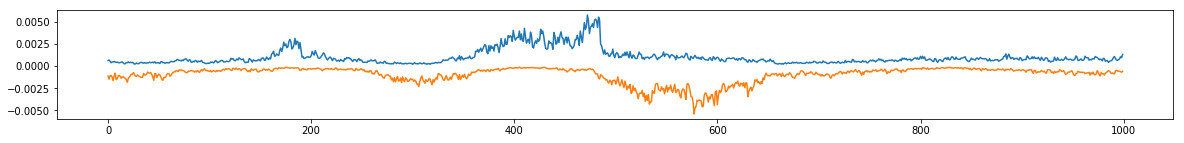

Alt allele counts imp


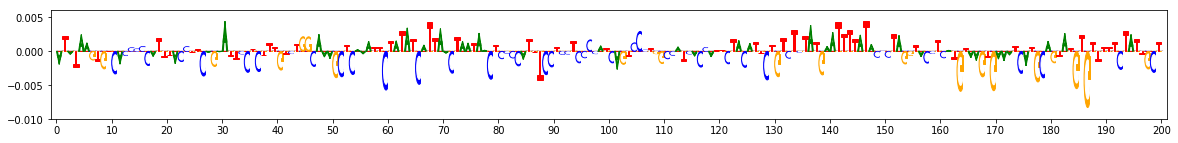

Alt allele profile imp


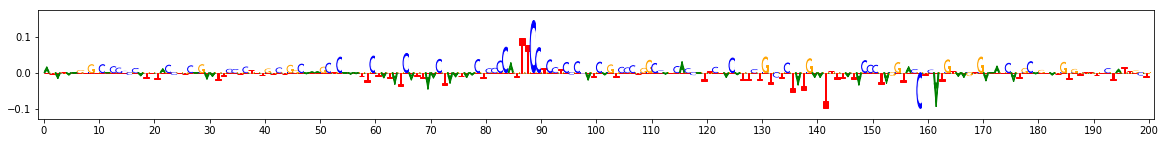

idx, snp pos 19015380 19015381 logratio -3.953214929244744 pvalue 1.04024977748099e-126
Post allele, counts pred [2.2610316 2.2323904]
Post allele profile pred


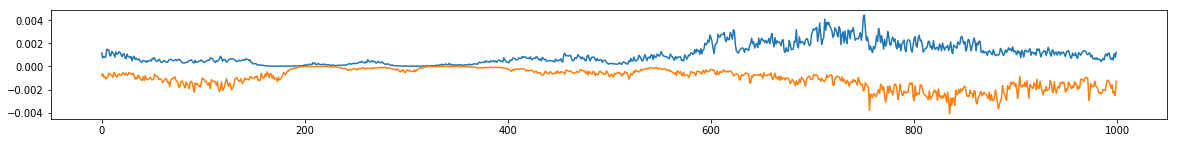

Post allele counts imp


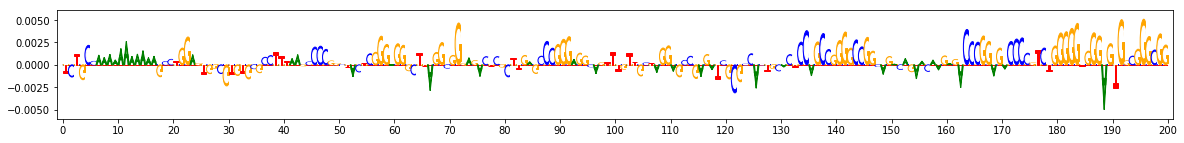

Post allele profile imp


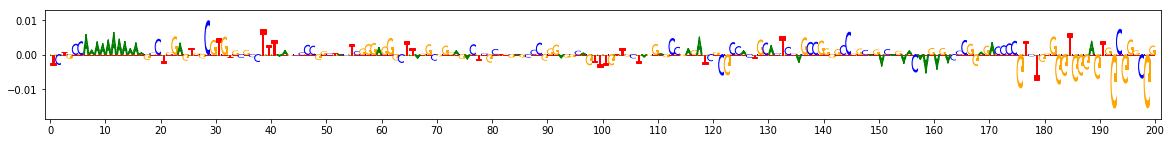

Alt allele:
Alt allele, counts pred [2.2611456 2.2301633]


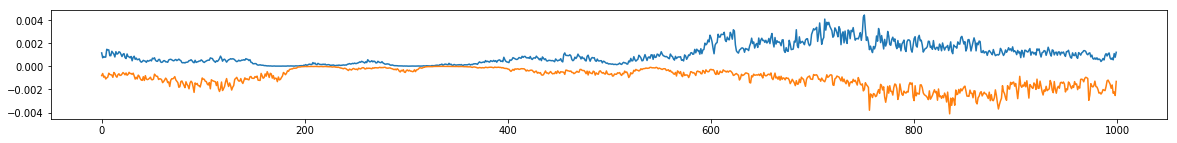

Alt allele counts imp


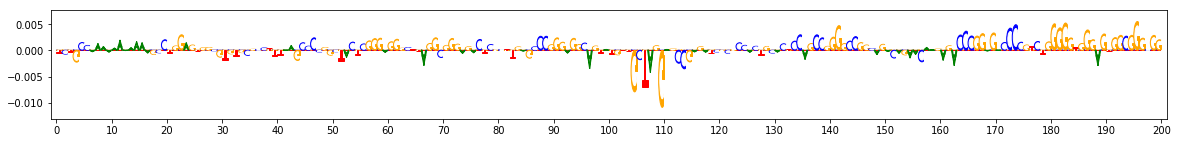

Alt allele profile imp


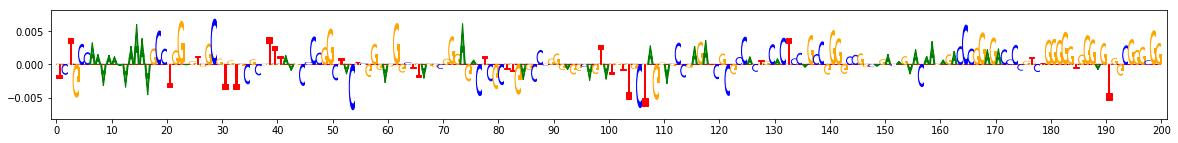

idx, snp pos 203372484 203372485 logratio -3.9460621085600334 pvalue 1.20543627955117e-05
Post allele, counts pred [1.9194235 1.9785285]
Post allele profile pred


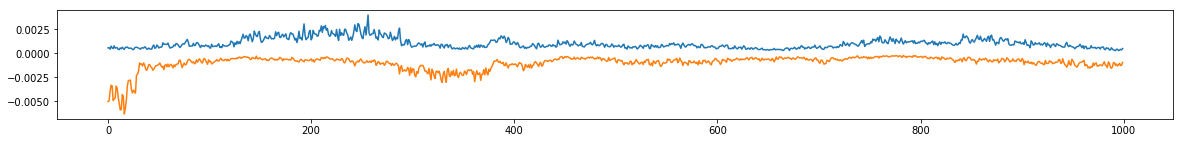

Post allele counts imp


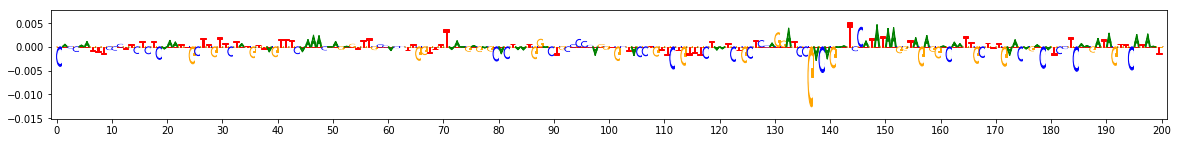

Post allele profile imp


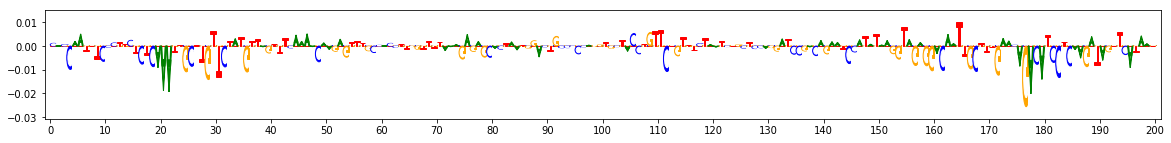

Alt allele:
Alt allele, counts pred [1.9182868 1.9775875]


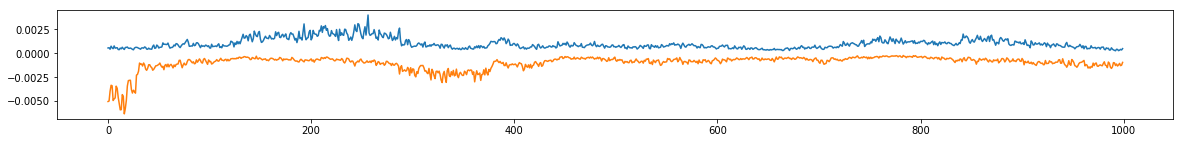

Alt allele counts imp


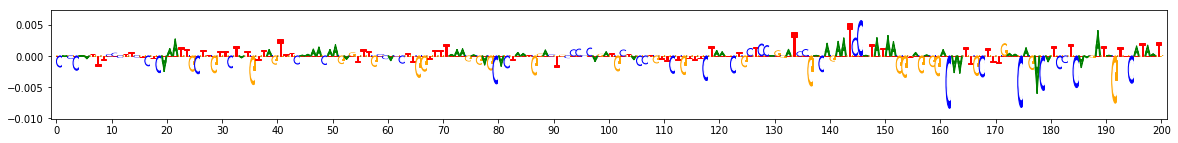

Alt allele profile imp


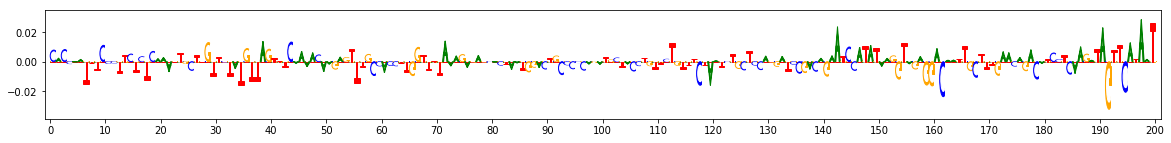

idx, snp pos 67589568 67589569 logratio -3.942978791687778 pvalue 6.27396945389492e-06
Post allele, counts pred [1.9706953 2.027323 ]
Post allele profile pred


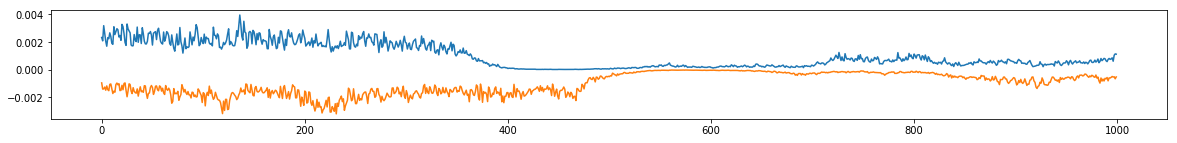

Post allele counts imp


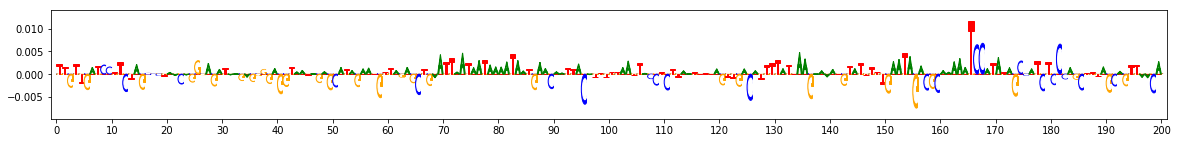

Post allele profile imp


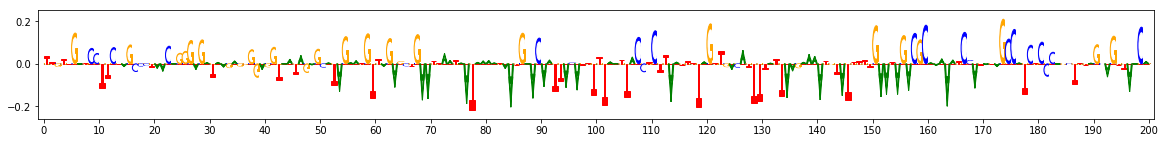

Alt allele:
Alt allele, counts pred [1.9712598 2.0276492]


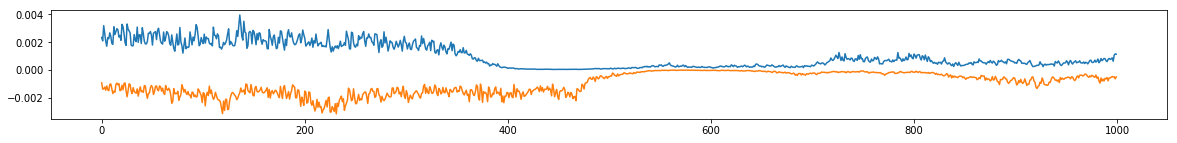

Alt allele counts imp


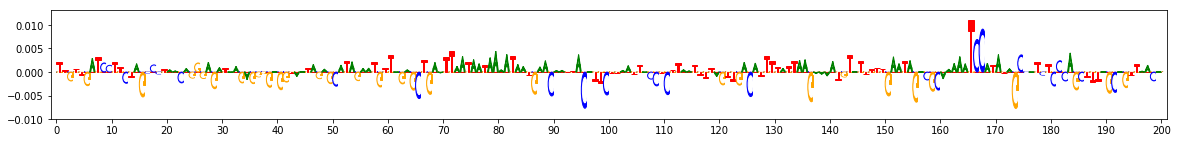

Alt allele profile imp


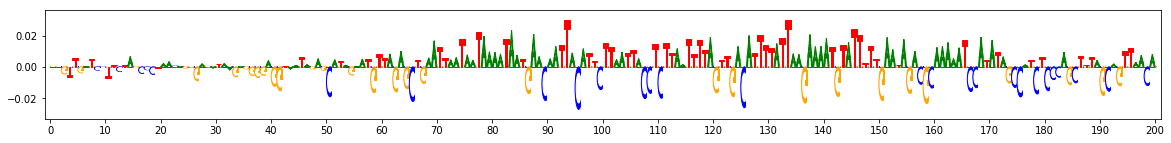

idx, snp pos 66133778 66133779 logratio -3.9292741279452645 pvalue 3.8191049241283e-06
Post allele, counts pred [2.002791  1.9759394]
Post allele profile pred


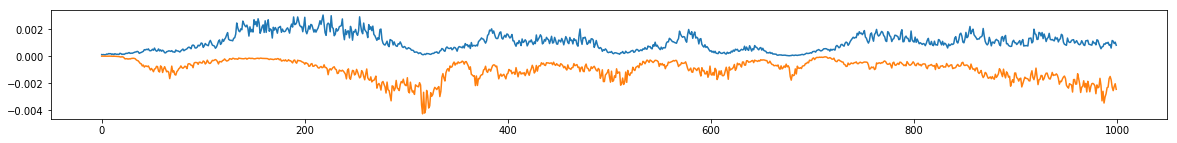

Post allele counts imp


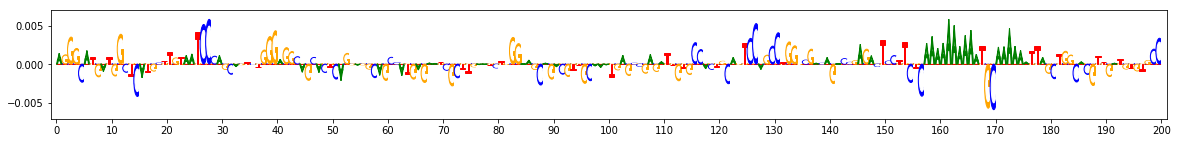

Post allele profile imp


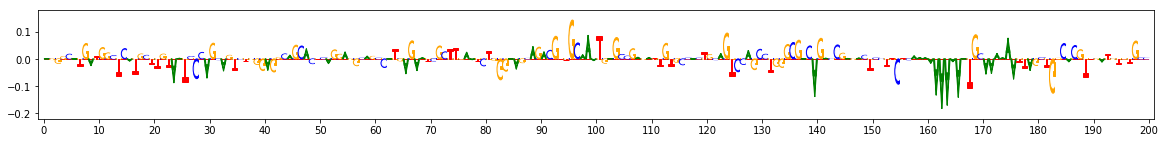

Alt allele:
Alt allele, counts pred [2.0031044 1.9771767]


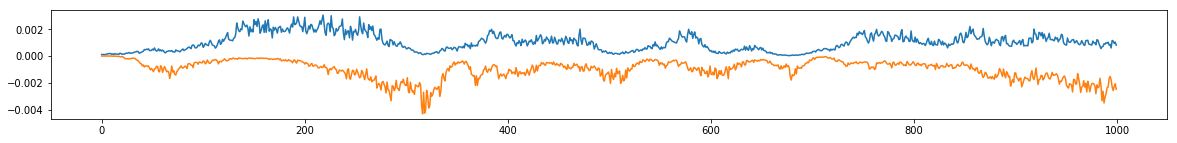

Alt allele counts imp


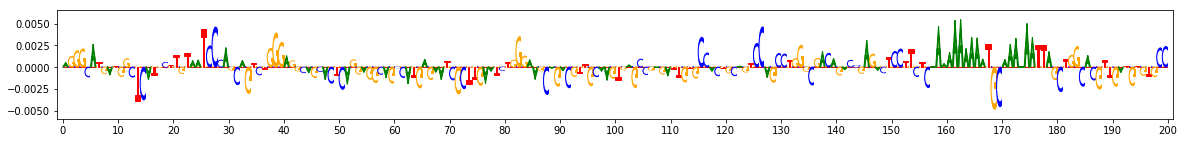

Alt allele profile imp


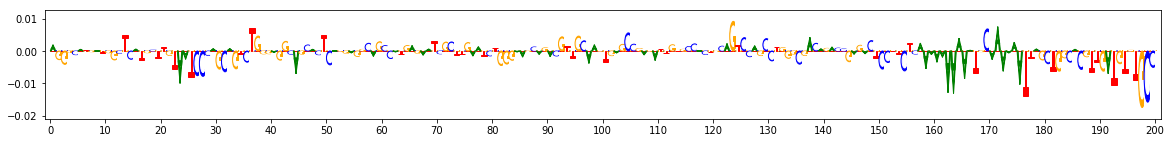

In [19]:
from deeplift.visualization import viz_sequence
from matplotlib import pyplot as plt
from scipy.special import softmax

for i in range(10):
  bqtl = significant_bqtls[i]
  print("idx, snp pos",bqtl.start, bqtl.end,
        "logratio", bqtl.logratio, "pvalue", bqtl.pvalue)
  print("Post allele, counts pred",bqtl.post_counts_pred)
  print("Post allele profile pred")
  post_profile_pred = softmax(bqtl.post_profile_pred, axis=0)
  fig = plt.figure(figsize=(20,2))
  plt.plot(post_profile_pred[:,0])
  plt.plot(post_profile_pred[:,1]*-1)
  plt.show()
  print("Post allele counts imp")
  viz_sequence.plot_weights(bqtl.post_counts_actualimp[573:773],
                            subticks_frequency=10)
  print("Post allele profile imp")
  viz_sequence.plot_weights(bqtl.post_profile_actualimp[573:773],
                            subticks_frequency=10)
  
  print("Alt allele:")
  print("Alt allele, counts pred",bqtl.alt_counts_pred)  
  alt_profile_pred = softmax(bqtl.alt_profile_pred, axis=0)
  fig = plt.figure(figsize=(20,2))
  plt.plot(alt_profile_pred[:,0])
  plt.plot(alt_profile_pred[:,1]*-1)
  plt.show()
  print("Alt allele counts imp")
  viz_sequence.plot_weights(bqtl.alt_counts_actualimp[573:773],
                            subticks_frequency=10)
  print("Alt allele profile imp")
  viz_sequence.plot_weights(bqtl.alt_profile_actualimp[573:773],
                            subticks_frequency=10)
